# Candidate models outcomes

In [ ]:
import logging
import numpy as np
from sklearn.base import clone
from pathlib import Path
import pickle
import pandas as pd
from sklearn.metrics import roc_auc_score, RocCurveDisplay, brier_score_loss
from sklearn.calibration import CalibrationDisplay
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import matplotlib.pyplot as plt
import mlflow

%matplotlib inline

In [ ]:
# from load_data import CATEGORICAL_FEATURES_RENAMED, RENAME_LABELS_DICT, X_test, X_train, y_test, y_train

In [ ]:
candidate_result_folder = Path.cwd().parent / "chirurgie-desire/results"
figure_folder = Path.cwd() / "figures"
result_folder = Path.cwd() / "results"


In [ ]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [ ]:
import matplotlib
import matplotlib.figure


class NestedCrossValidator:
    def __init__(
        self,
        estimator,
        param_grid,
        outer_cv_splits=5,
        inner_cv_splits=5,
        scoring=["roc_auc", "neg_brier_score", "neg_log_loss"],
        n_jobs=-1,
        verbose=0,
        random_state=420,
    ):
        self.estimator = estimator
        self.param_grid = param_grid
        self.outer_cv_splits = outer_cv_splits
        self.inner_cv_splits = inner_cv_splits
        self.scoring = scoring
        self.n_jobs = n_jobs
        self.verbose = verbose
        self.random_state = random_state
        self.ROCs = []
        self.briers = []
        self.best_model = None
        self.best_ROC = -float("inf")
        self.results = []  # Store results for plotting purposes
        self.ROC_plots: list[RocCurveDisplay] = []
        self.calibration_plots: list[CalibrationDisplay] = []
        self.plots: list[matplotlib.figure.Figure] = []

    def fit(self, X, y):
        logger.info(
            f"Starting Nested Cross-Validation for model {str(type(self.estimator.named_steps['classifier']).__name__)}"
        )
        outer_cv = StratifiedKFold(n_splits=self.outer_cv_splits, shuffle=True)  # , random_state=self.random_state)
        # outer_cv = TimeSeriesSplit(n_splits=self.outer_cv_splits)

        fold_number = 1
        with mlflow.start_run(run_name=f"outer_fold_{fold_number}", nested=True):
            for train_idx, test_idx in outer_cv.split(X, y):
                logger.info(
                    f"Starting outer fold {fold_number}/{self.outer_cv_splits} for model {str(type(self.estimator.named_steps['classifier']).__name__)}"
                )
                estimator_clone = clone(self.estimator)

                grid_search = GridSearchCV(
                    estimator_clone,
                    self.param_grid,
                    # cv=KFold(
                    #     n_splits=self.inner_cv_splits,
                    #     shuffle=True,
                    #     random_state=self.random_state,
                    # ),
                    # cv=TimeSeriesSplit(n_splits=self.inner_cv_splits),
                    cv=StratifiedKFold(n_splits=self.inner_cv_splits, shuffle=True),
                    scoring=self.scoring,
                    n_jobs=self.n_jobs,
                    verbose=self.verbose,
                    refit="neg_log_loss",
                    error_score="raise",
                )

                logger.info(
                    f"Starting GridSearchCV for outer fold {fold_number} for model {str(type(estimator_clone.named_steps['classifier']).__name__)}"
                )
                grid_search.fit(X.iloc[train_idx], y.iloc[train_idx])
                logger.info(
                    f"Completed GridSearchCV for outer fold {fold_number} for model {str(type(estimator_clone.named_steps['classifier']).__name__)}"
                )

                test_ROC = roc_auc_score(
                    y_true=y.iloc[test_idx], y_score=grid_search.predict_proba(X.iloc[test_idx])[:, 1].ravel()
                )

                self.ROCs.append(test_ROC)
                logger.info(f"Test ROC for outer fold {fold_number}: {test_ROC:.4f}")

                test_brier = brier_score_loss(
                    y_true=y.iloc[test_idx], y_proba=grid_search.predict_proba(X.iloc[test_idx])[:, 1]
                )

                self.briers.append(test_brier)
                logger.info(f"Test brier for outer fold {fold_number}: {test_brier:.4f}")

                fig, axs = plt.subplots(1, 2)
                roc_plot: RocCurveDisplay = RocCurveDisplay.from_estimator(
                    grid_search, X=X.iloc[test_idx], y=y.iloc[test_idx], ax=axs[0]
                )
                self.ROC_plots.append(roc_plot)

                calibration_plot: CalibrationDisplay = CalibrationDisplay.from_estimator(
                    grid_search, X=X.iloc[test_idx], y=y.iloc[test_idx], n_bins=20, ax=axs[1]
                )
                self.calibration_plots.append(calibration_plot)

                self.plots.append(fig)
                plt.close(fig)

                if test_ROC > self.best_ROC:
                    self.best_ROC = test_ROC
                    self.best_model = grid_search.best_estimator_
                    logger.info(
                        f"New best {str(type(estimator_clone.named_steps['classifier']).__name__)} model found in outer fold {fold_number} with ROC {test_ROC:.4f}"
                    )
                    logger.info(
                        f"Best parameters for this {str(type(estimator_clone.named_steps['classifier']).__name__)} model: {grid_search.best_params_}"
                    )

                # Store results for plotting
                self.results.append((grid_search.best_estimator_, X.iloc[test_idx], y.iloc[test_idx]))

                fold_number += 1

        average_ROC = self.get_average_ROC()
        ROC_std = self.get_ROC_std()
        logger.info(
            f"Average test ROC across all folds: {average_ROC:.4f} for model {str(type(estimator_clone.named_steps['classifier']).__name__)}"
        )
        logger.info(
            f"Standard deviation of test ROCs across all folds: {ROC_std:.4f} for model {str(type(estimator_clone.named_steps['classifier']).__name__)}"
        )

        average_Brier = self.get_average_Brier()
        Brier_std = self.get_Brier_std()
        logger.info(
            f"Average test Brier across all folds: {average_Brier:.4f} for model {str(type(estimator_clone.named_steps['classifier']).__name__)}"
        )
        logger.info(
            f"Standard deviation of test Briers across all folds: {Brier_std:.4f} for model {str(type(estimator_clone.named_steps['classifier']).__name__)}"
        )
        logger.info("Completed Nested Cross-Validation")
        return self

    def get_average_ROC(self):
        return sum(self.ROCs) / len(self.ROCs) if self.ROCs else None

    def get_ROC_std(self):
        return np.std(self.ROCs) if self.ROCs else None

    def get_average_Brier(self):
        return sum(self.briers) / len(self.briers) if self.briers else None

    def get_Brier_std(self):
        return np.std(self.briers) if self.briers else None

    def get_model_performance(self):
        performance_dict = {}
        performance_dict["mean_ROC"] = self.get_average_ROC()
        performance_dict["std_ROC"] = self.get_ROC_std()
        performance_dict["mean_Brier"] = self.get_average_Brier()
        performance_dict["std_Brier"] = self.get_Brier_std()
        return performance_dict

    def get_best_model(self):
        return self.best_model

    def get_results(self):
        return self.results

In [ ]:
with open(candidate_result_folder / "cross_val_results_paper_rf.pkl", "rb") as file:
    rf_nested_cv = pickle.load(file)
with open(candidate_result_folder / "cross_val_results_paper_xgb.pkl", "rb") as file:
    xgb_nested_cv = pickle.load(file)
with open(candidate_result_folder / "cross_val_results_paper_lr.pkl", "rb") as file:
    logreg_nested_cv = pickle.load(file)

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [ ]:
# Print performance
val_scores = {
    "Random Forest": rf_nested_cv.get_model_performance(),
    "XGBoost": xgb_nested_cv.get_model_performance(),
    "Logistic regression": logreg_nested_cv.get_model_performance(),
}
val_score_df = pd.DataFrame(val_scores)
display(val_score_df)
# val_score_df.to_excel(result_folder / "Validation_score.xlsx")

,Random Forest,XGBoost,Logistic regression
mean_ROC,0.788116,0.792946,0.789482
std_ROC,0.025030,0.011352,0.023828
mean_Brier,0.167988,0.164778,0.166130
std_Brier,0.006803,0.004080,0.008788


In [ ]:
def plot_mean_roc(models, n_points=100, chance_line=True):
    """
    Plots the mean ROC curve with 95% CI for each model using Matplotlib.
    The plot is square and both x- and y-axes are forced to range from 0 to 1.

    Parameters:
    - models: dict
        Dictionary mapping model names to lists of RocCurveDisplay objects.
        Each object is expected to have .fpr and .tpr arrays.
    - n_points: int
        Number of points for the common FPR grid.
    - chance_line: bool
        Whether to add the diagonal chance line.

    Returns:
    - Figure to save plot
    """
    # Define a common FPR grid.
    fpr_common = np.linspace(0, 1, n_points)

    fig = plt.figure(figsize=(6, 6))

    for model_name, roc_list in models.items():
        interp_tprs = []
        for roc in roc_list:
            # Interpolate TPR values on the common FPR grid.
            interp_tpr = np.interp(fpr_common, roc.fpr, roc.tpr)
            interp_tprs.append(interp_tpr)
        interp_tprs = np.array(interp_tprs)

        # Compute the mean and the 95% CI.
        mean_tpr = np.mean(interp_tprs, axis=0)
        lower_tpr = np.percentile(interp_tprs, 2.5, axis=0)
        upper_tpr = np.percentile(interp_tprs, 97.5, axis=0)

        # Plot the mean ROC curve.
        plt.plot(fpr_common, mean_tpr, label=f"{model_name} ROC")
        # Fill the area between the 95% CI bounds.
        plt.fill_between(fpr_common, lower_tpr, upper_tpr, alpha=0.2)

    if chance_line:
        # Plot the chance line.
        plt.plot([0, 1], [0, 1], color="black", linestyle="--", label="Chance")

    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Mean ROC Curve with 95% CI")
    plt.legend()
    plt.grid(True)
    # Set aspect ratio to be equal.
    plt.gca().set_aspect("equal", adjustable="box")
    return fig


In [ ]:
def plot_mean_calibration(models, n_points=100):
    """
    Plots the mean calibration curve with 95% CI for each model using Matplotlib.

    Parameters:
    - models: dict
        Dictionary mapping model names to lists of CalibrationDisplay objects.
        Each object is expected to have attributes .prob_pred (x-values) and .prob_true (y-values).
    - n_points: int
        Number of points for the common x grid.

    Returns:
    - Figure to save plot
    """
    # Define a common x grid.
    x_common = np.linspace(0, 1, n_points)

    fig = plt.figure(figsize=(6, 9))
    gs = fig.add_gridspec(nrows=11, ncols=1)

    ax_calibration_curve = fig.add_subplot(gs[:8, 0])

    # Add histogram
    ax_hist = fig.add_subplot(gs[-2:, 0], sharex=ax_calibration_curve)

    for model_name, calib_list in models.items():
        interp_ys = []
        y_probs = np.empty(0)
        for calib in calib_list:
            # Use .prob_pred and .prob_true for calibration data.
            x_vals = getattr(calib, "prob_pred", None)
            y_vals = getattr(calib, "prob_true", None)
            y_prob = getattr(calib, "y_prob", None)

            if x_vals is None or y_vals is None:
                raise AttributeError("CalibrationDisplay object must have attributes 'prob_pred' and 'prob_true'.")

            # Interpolate the y-values on the common x grid.
            interp_y = np.interp(x_common, x_vals, y_vals)
            interp_ys.append(interp_y)
            y_probs = np.append(y_probs, y_prob)
        interp_ys = np.array(interp_ys)

        # Compute the mean and the 95% CI.
        mean_y = np.mean(interp_ys, axis=0)
        lower_y = np.percentile(interp_ys, 2.5, axis=0)
        upper_y = np.percentile(interp_ys, 97.5, axis=0)

        # Plot the mean calibration curve.
        ax_calibration_curve.plot(x_common, mean_y, label=f"{model_name}")
        # Fill the area between the 95% CI bounds.
        ax_calibration_curve.fill_between(x_common, lower_y, upper_y, alpha=0.2)

        # Add histogram
        ax_hist.hist(
            y_probs,
            range=(0, 1),
            bins=20,
            alpha=0.2,
        )

    # Plot the perfect calibration identity line.
    ax_calibration_curve.plot([0, 1], [0, 1], color="black", linestyle="--", label="Perfect Calibration")

    ax_calibration_curve.set_xlim(0, 1)
    ax_calibration_curve.set_ylim(0, 1)
    ax_calibration_curve.set_xlabel("Predicted Probability")
    ax_calibration_curve.set_ylabel("Fraction of Positives")
    ax_calibration_curve.set_title("Mean Calibration Curve with 95% CI")
    ax_calibration_curve.legend()
    ax_calibration_curve.grid(True)
    ax_calibration_curve.spines["top"].set_visible(False)
    ax_calibration_curve.spines["right"].set_visible(False)
    ax_hist.spines["top"].set_visible(False)
    ax_hist.spines["right"].set_visible(False)
    # Set aspect ratio to be equal.
    ax_calibration_curve.set_aspect("equal", adjustable="box")
    ax_hist.set(title="Histogram", xlabel="Predicted probability", ylabel="Count")
    return fig


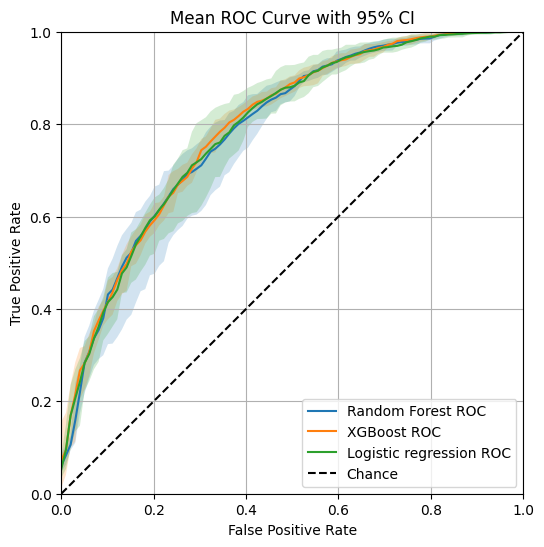

In [ ]:
# Suppose you have three models with lists of RocCurveDisplay objects:
models_roc = {
    "Random Forest": rf_nested_cv.ROC_plots,
    "XGBoost": xgb_nested_cv.ROC_plots,
    "Logistic regression": logreg_nested_cv.ROC_plots,
}

fig_roc = plot_mean_roc(models_roc)
fig_roc.savefig(f"{figure_folder}/mean_val_ROC.png")


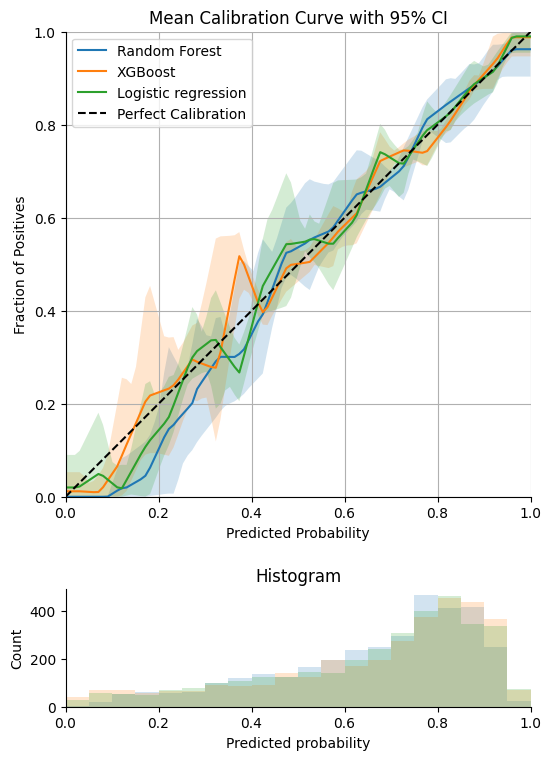

In [ ]:
models_calib = {
    "Random Forest": rf_nested_cv.calibration_plots,
    "XGBoost": xgb_nested_cv.calibration_plots,
    "Logistic regression": logreg_nested_cv.calibration_plots,
}

fig_calib = plot_mean_calibration(models_calib)
fig_calib.savefig(f"{figure_folder}/mean_val_calibration.png")
fig_calib.savefig(f"{figure_folder}/mean_val_calibration.svg")
